In [11]:
#start with importing the libraries we will need in this project.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#to account for the computation requirements, I am using google colab to execute my code.
from google.colab import drive
drive.mount('/content/drive')

In [13]:
''' First lets import the datasets we have.
'''
train_data = pd.read_csv('//content/drive/My Drive/Colab Notebooks/classification/facies_data.csv')

In [14]:
train_data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [15]:
train_data.info()
'''we dont have missing values so we can start with EDA'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Facies     3232 non-null   int64  
 1   Formation  3232 non-null   object 
 2   Well Name  3232 non-null   object 
 3   Depth      3232 non-null   float64
 4   GR         3232 non-null   float64
 5   ILD_log10  3232 non-null   float64
 6   DeltaPHI   3232 non-null   float64
 7   PHIND      3232 non-null   float64
 8   PE         3232 non-null   float64
 9   NM_M       3232 non-null   int64  
 10  RELPOS     3232 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 277.9+ KB


'we dont have missing values so we can start with EDA'

In [16]:
#to make it easier to follow the code, lets change the 'facies' header to 'class'
train_data.rename(columns={'Facies': 'class'}, inplace=True)

In [92]:
def plot_logs(data):
    #sort data by depth
    data = data.sort_values(by = 'Depth')
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(18, 12))
    ax[0].plot(data['GR'], data['Depth'], '-g')
    ax[1].plot(data['ILD_log10'], data['Depth'], '-b')
    ax[2].plot(data['DeltaPHI'], data['Depth'], '-', color='0.5')
    ax[3].plot(data['PHIND'], data['Depth'], '-', color='r')
    ax[4].plot(data['PE'], data['Depth'], '-', color='black')
    
    #lets add labels for the x-axis
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(data['GR'].min(),data['GR'].max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(data['ILD_log10'].min(),data['ILD_log10'].max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(data['DeltaPHI'].min(),data['DeltaPHI'].max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(data['PHIND'].min(),data['PHIND'].max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(data['PE'].min(),data['PE'].max())

    #add label to the y-axis
    ax[0].set_ylabel('Depth')

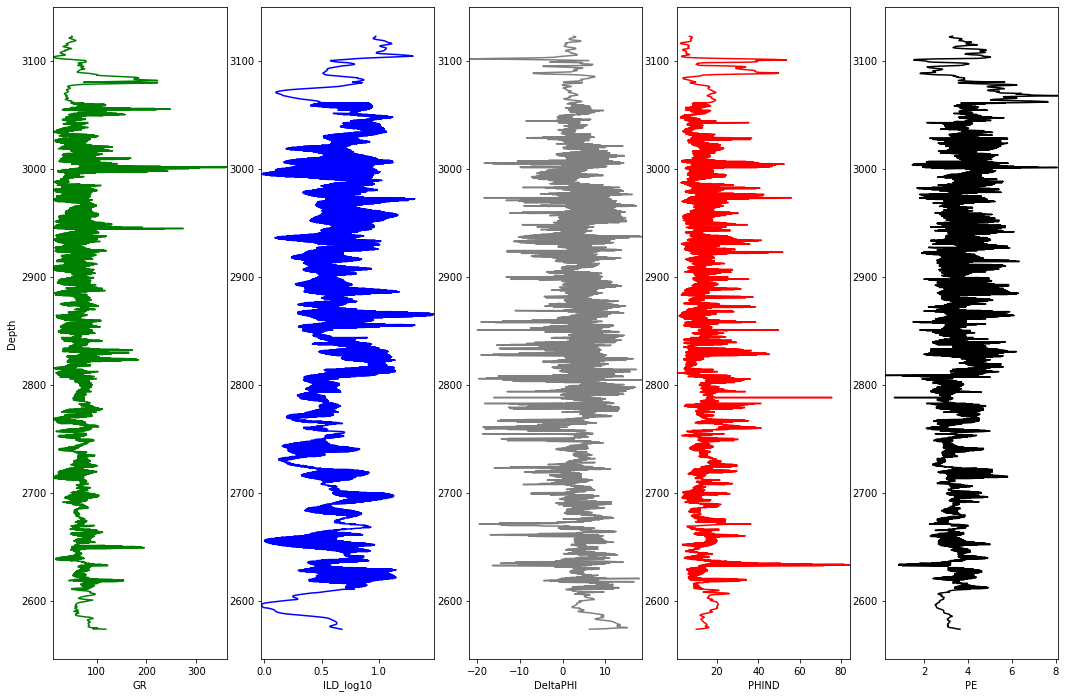

In [93]:
plot_logs(train_data)

lets visualise the distribution of the classes.

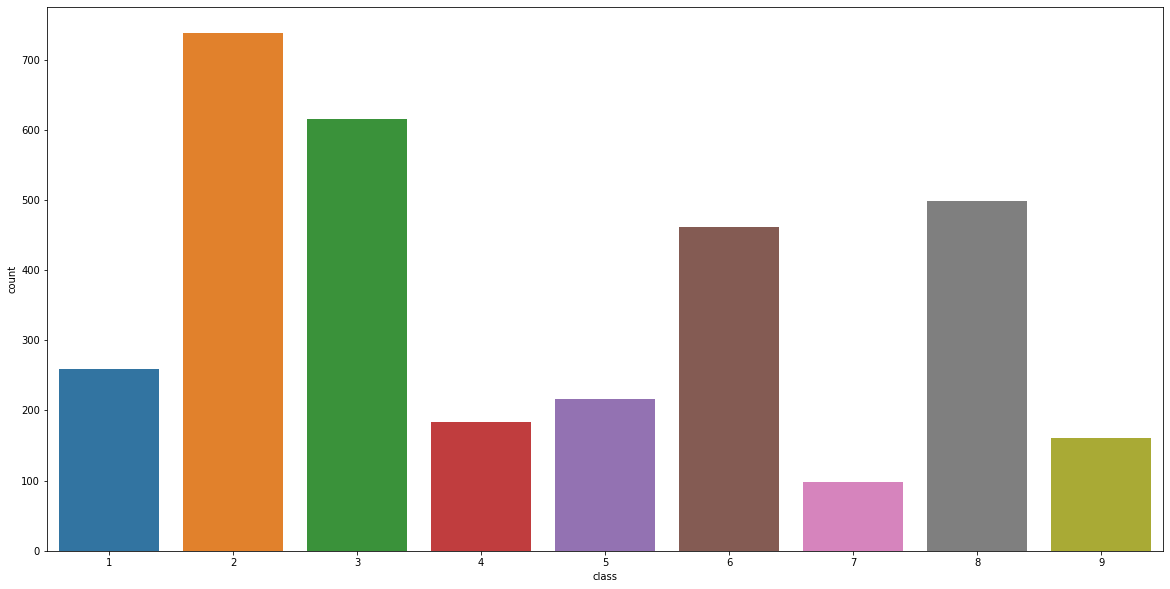

In [19]:
fig = plt.figure(figsize = (20,10))
plot = sns.countplot(x="class", data=train_data)

In [21]:
#one hot encoding the categorical data

train_data = pd.get_dummies(train_data, columns =['Formation','Well Name'])

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3232 entries, 0 to 3231
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   class                      3232 non-null   int64  
 1   Depth                      3232 non-null   float64
 2   GR                         3232 non-null   float64
 3   ILD_log10                  3232 non-null   float64
 4   DeltaPHI                   3232 non-null   float64
 5   PHIND                      3232 non-null   float64
 6   PE                         3232 non-null   float64
 7   NM_M                       3232 non-null   int64  
 8   RELPOS                     3232 non-null   float64
 9   Formation_A1 LM            3232 non-null   uint8  
 10  Formation_A1 SH            3232 non-null   uint8  
 11  Formation_B1 LM            3232 non-null   uint8  
 12  Formation_B1 SH            3232 non-null   uint8  
 13  Formation_B2 LM            3232 non-null   uint8

#Lets start the Machine Learning stuff. 

I will be using multiple models in this project: Catboost, Decision Trees and Random forest. If the performance is not that good, I will consider using the LSTM algorithm. 

In [46]:
#import the need libraries and tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

#Catboost 
from catboost import Pool, CatBoostClassifier

#decision tree
from sklearn.tree import DecisionTreeClassifier

#random forest
from sklearn.ensemble import RandomForestClassifier

#xgboost 
from xgboost import XGBClassifier
print('all required libraries imported')

all required libraries imported


Train-test Split

In [25]:
x_data = train_data.drop(columns = 'class')
y_data = train_data['class']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)

Lets scale the numerical values using the StandardScaler


In [26]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#Base Model: Random Forest Classifier
Now lets try a base model to set a benchmark. Lets use the Random Forest estimator.

In [70]:
#try random forest classifier
classifier = RandomForestClassifier(random_state = 42)

In [29]:
#grid search to fine tune the parameters of the random forest classifier
n_estimators = [25, 100, 500, 800]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 5] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(classifier, hyperF, scoring = 'accuracy', cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(x_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  7.6min finished


In [30]:
print(gridF.best_params_)

{'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 800}


In [73]:
#using the best parameters 
classifier2 = RandomForestClassifier(n_estimators = 800, max_depth = 25,min_samples_leaf = 1, min_samples_split = 2 , random_state = 42)
classifier2.fit(x_train, y_train)
y_pred_rf_best = classifier2.predict(x_test)
print(classification_report(y_test, y_pred_rf_best))
print('Our benchmark accuracy score is', accuracy_score(y_test, y_pred_rf_best))
rf_accuracy = accuracy_score(y_test, y_pred_rf_best)

              precision    recall  f1-score   support

           1       0.96      0.96      0.96        46
           2       0.85      0.92      0.89       153
           3       0.87      0.81      0.84       126
           4       0.63      0.79      0.70        28
           5       0.86      0.64      0.73        47
           6       0.85      0.82      0.84       100
           7       0.79      0.68      0.73        22
           8       0.81      0.87      0.84        94
           9       0.94      1.00      0.97        31

    accuracy                           0.85       647
   macro avg       0.84      0.83      0.83       647
weighted avg       0.85      0.85      0.85       647

our benchmark accuracy score is 0.848531684698609


#Now lets test our next algorithm/model: Catboost

In [32]:
#try catboost model
catboost = CatBoostClassifier()
catboost.fit(x_train, y_train)
y_pred_cat = catboost.predict(x_test)
print(classification_report(y_test, y_pred_cat))
print('accuracy score is', accuracy_score(y_test, y_pred_cat))

Learning rate set to 0.083054
0:	learn: 2.0299200	total: 66.7ms	remaining: 1m 6s
1:	learn: 1.9071465	total: 83.8ms	remaining: 41.8s
2:	learn: 1.8011889	total: 101ms	remaining: 33.4s
3:	learn: 1.7047579	total: 116ms	remaining: 29s
4:	learn: 1.6311579	total: 133ms	remaining: 26.5s
5:	learn: 1.5639092	total: 150ms	remaining: 24.9s
6:	learn: 1.5079506	total: 167ms	remaining: 23.7s
7:	learn: 1.4487142	total: 188ms	remaining: 23.4s
8:	learn: 1.3987559	total: 207ms	remaining: 22.8s
9:	learn: 1.3495985	total: 223ms	remaining: 22.1s
10:	learn: 1.3106569	total: 238ms	remaining: 21.4s
11:	learn: 1.2751713	total: 254ms	remaining: 20.9s
12:	learn: 1.2426706	total: 270ms	remaining: 20.5s
13:	learn: 1.2117397	total: 285ms	remaining: 20.1s
14:	learn: 1.1852654	total: 300ms	remaining: 19.7s
15:	learn: 1.1580190	total: 315ms	remaining: 19.3s
16:	learn: 1.1340875	total: 330ms	remaining: 19.1s
17:	learn: 1.1118980	total: 345ms	remaining: 18.8s
18:	learn: 1.0900495	total: 360ms	remaining: 18.6s
19:	learn: 

In [ ]:
#parameters tuning of the catboost
#this takes a long time so I just commented it out. 
'''
model_cat = CatBoostClassifier(random_state=42)
parameters = {'depth' : [5,10, 15],
                  #'learning_rate' : [0.01, 0.1],
                  'iterations'    : [2000, 3000]
                 }
grid = GridSearchCV(estimator=model_cat, scoring = 'accuracy', param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(x_train, y_train)

print(grid.best_params_)'''


In [34]:
#classifier with best parameters
best_catboost = CatBoostClassifier(iterations=2000, learning_rate=0.1)
best_catboost.fit(x_train, y_train)
y_pred_cat_best = best_catboost.predict(x_test)

0:	learn: 1.9974742	total: 16.5ms	remaining: 33s
1:	learn: 1.8574703	total: 33ms	remaining: 33s
2:	learn: 1.7399751	total: 48.3ms	remaining: 32.2s
3:	learn: 1.6357546	total: 63.6ms	remaining: 31.7s
4:	learn: 1.5579699	total: 79.3ms	remaining: 31.6s
5:	learn: 1.4878886	total: 94.8ms	remaining: 31.5s
6:	learn: 1.4302149	total: 110ms	remaining: 31.4s
7:	learn: 1.3694957	total: 127ms	remaining: 31.7s
8:	learn: 1.3192747	total: 143ms	remaining: 31.6s
9:	learn: 1.2704806	total: 165ms	remaining: 32.7s
10:	learn: 1.2326745	total: 181ms	remaining: 32.6s
11:	learn: 1.1974260	total: 196ms	remaining: 32.5s
12:	learn: 1.1661939	total: 213ms	remaining: 32.6s
13:	learn: 1.1362455	total: 234ms	remaining: 33.2s
14:	learn: 1.1110646	total: 250ms	remaining: 33s
15:	learn: 1.0859008	total: 268ms	remaining: 33.3s
16:	learn: 1.0630081	total: 285ms	remaining: 33.2s
17:	learn: 1.0404173	total: 301ms	remaining: 33.1s
18:	learn: 1.0214354	total: 316ms	remaining: 32.9s
19:	learn: 1.0004817	total: 331ms	remaining

In [74]:
print(classification_report(y_test, y_pred_cat_best))
print('Best accuracy score by catboost is', accuracy_score(y_test, y_pred_cat_best))
catboost_accuracy = accuracy_score(y_test, y_pred_cat_best)

              precision    recall  f1-score   support

           1       0.93      0.93      0.93        46
           2       0.85      0.92      0.88       153
           3       0.88      0.80      0.84       126
           4       0.58      0.79      0.67        28
           5       0.84      0.66      0.74        47
           6       0.86      0.80      0.83       100
           7       0.88      0.68      0.77        22
           8       0.78      0.85      0.82        94
           9       0.91      1.00      0.95        31

    accuracy                           0.84       647
   macro avg       0.84      0.83      0.83       647
weighted avg       0.84      0.84      0.84       647

best accuracy score by catboost is 0.839258114374034


#Now lets test our next algorithm/model: DecisionTreeClassifier

In [ ]:
#Decision Tree Model

DTclassifier = DecisionTreeClassifier(criterion='gini', max_depth=1000)

DTclassifier.fit(x_train, y_train)
y_pred_DT = DTclassifier.predict(x_test)

In [75]:
print(classification_report(y_test, y_pred_DT))
print('best accuracy score by Decision Tree is', accuracy_score(y_test, y_pred_DT))
dt_accuracy = accuracy_score(y_test, y_pred_DT)

              precision    recall  f1-score   support

           1       0.71      0.96      0.81        46
           2       0.79      0.75      0.77       153
           3       0.81      0.73      0.77       126
           4       0.59      0.82      0.69        28
           5       0.74      0.60      0.66        47
           6       0.77      0.71      0.74       100
           7       0.72      0.82      0.77        22
           8       0.68      0.69      0.68        94
           9       0.83      0.97      0.90        31

    accuracy                           0.75       647
   macro avg       0.74      0.78      0.75       647
weighted avg       0.75      0.75      0.75       647

best accuracy score by Decision Tree is 0.749613601236476


The accuracy is much lower than the other algorithms tested already. So I did not bother fine tuning the parameters of the Decision Tree model.

#Now lets test our next algorithm/model: XGBClassifier

In [57]:
xgb_model = XGBClassifier()

parameters = {'max_depth' : [5,10, 15],
                  'n_estimators' : [250, 500, 750],
                  #'learning_rate' : [0.05, 0.1, 0.3]
                 }
grid = GridSearchCV(estimator=xgb_model, scoring = 'accuracy', param_grid = parameters, cv = 3, n_jobs=-1)
grid.fit(x_train, y_train)

print(grid.best_params_)                     

{'max_depth': 10, 'n_estimators': 500}


In [ ]:
xgb_clf = XGBClassifier(max_depth=10, n_estimators=500, seed=42)
xgb_clf.fit(x_train, y_train)
y_pred_xgb = xgb_clf.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred_xgb))
print('best accuracy score by xgbboost is', accuracy_score(y_test, y_pred_xgb))
xgb_accuracy =accuracy_score(y_test, y_pred_xgb)

              precision    recall  f1-score   support

           1       0.94      0.96      0.95        46
           2       0.85      0.90      0.87       153
           3       0.88      0.83      0.85       126
           4       0.64      0.82      0.72        28
           5       0.76      0.62      0.68        47
           6       0.84      0.78      0.81       100
           7       0.71      0.68      0.70        22
           8       0.76      0.83      0.80        94
           9       0.97      0.97      0.97        31

    accuracy                           0.83       647
   macro avg       0.82      0.82      0.82       647
weighted avg       0.83      0.83      0.83       647

best accuracy score by xgbboost is 0.8315301391035549


In [80]:
#summary
Models = ['xgboost_clf','Deicision Tree','Catboost_clf','Random_Forest_clf']
Accuracy = [xgb_accuracy,dt_accuracy, catboost_accuracy, rf_accuracy]
summary_results = pd.DataFrame()
summary_results['Model'] = Models
summary_results['Accuracy'] = Accuracy
print(summary_results)

               Model  Accuracy
0        xgboost_clf  0.831530
1     Deicision Tree  0.749614
2       Catboost_clf  0.839258
3  Random_Forest_clf  0.848532


#Summary
* Random forest classifier performs best with accuracy of 84.9%. While catboost and xgboost perform similarly. Decision tree is not a good choice for this particular problem.

* More data would be beneficial to get better results.

* Deep learning algorithms can be performed (like the Long Short-Term Memory LSTM algorithm) to get better results. However, it requires higher computational power than what I have.